# scMC Example

In [1]:
import scipy.stats
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append("..")
from scmc.models.scmc_model import scmc, generate_reads, sample_Sigma

## Set prior parameters

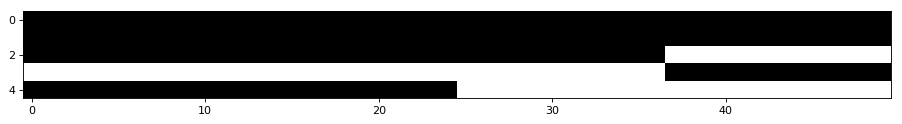

In [2]:
n = 50 # number of cells
d = 5 # number of genomic positions

# inverse Wishart prior
Lambda = np.eye(d) * 5 # scale matrix 
v = d # degrees of freedom

# beta prior
alpha = 2 * np.ones(d+1)
beta = 2 * np.ones(d+1)
beta[1] = 1
beta[0] = 50

# coverage parameters
dropout_prob = 0.5
poisson_mean = 20

# genotype matrix
U = np.zeros([d, n])
U[0:2, :] = 1 # germline
U[2, 0:(3*n//4)] = 1 
U[3, (3*n//4):n] = 1 
U[4, 0:(n//2)] = 1 

fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
p1 = plt.imshow(U, interpolation='nearest', cmap=plt.cm.afmhot_r)

## Generate data

In [3]:
# sample coverage at each genomic position
D = scipy.stats.bernoulli.rvs(1 - dropout_prob, size=[d,n]) 
D = D * scipy.stats.poisson.rvs(poisson_mean, size=[d,n])

# sample theta from prior
theta = scipy.stats.beta.rvs(a=alpha, b=beta)

# generate reads from prior
A = generate_reads(U, D, theta)

## Run model

In [4]:
[theta_hat, Sigma_hat, X_hat] = scmc(A, D, Lambda, v, alpha, beta, max_iter=1000)

100
200
300
400
500
600
700
800
900


In [5]:
err_x = np.logical_xor(X_hat>0, U>0).mean()
err_vaf = np.logical_xor(A/(D + 1e-5) > 0.1, U>0).mean()
err_theta = ((theta - theta_hat)**2).mean()
print("Genotype error: %.4f" % err_x)
print("VAF-base error: %.4f" % err_vaf)
print("theta    error: %.4f" % err_theta)

Genotype error: 0.0520
VAF-base error: 0.3400
theta    error: 0.0005


## Correlation analysis
To see how well we can recover the true correlation structure in our data, we compare
- Lambda, the prior parameter for Sigma
- Sigma sampled by scMC
- Sigma sampled from posterior based on true genotype
- Sigma sampled from posterior based on estimated genotype

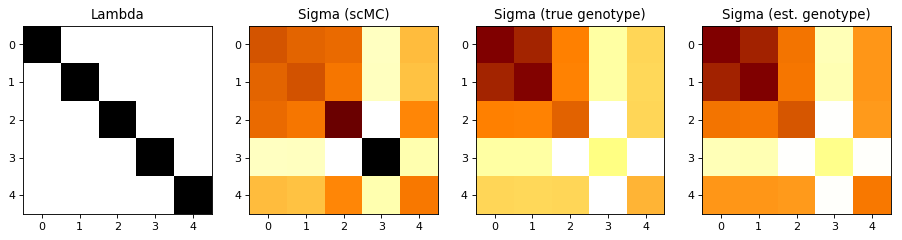

In [6]:
fig = plt.figure(figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1, 4, 1)
ax1.set_title('Lambda', size=12)
p1 = plt.imshow(Lambda, interpolation='nearest', cmap=plt.cm.afmhot_r)

ax2 = plt.subplot(1, 4, 2)
ax2.set_title('Sigma (scMC)', size=12)
p2 = plt.imshow(Sigma_hat, interpolation='nearest', cmap=plt.cm.afmhot_r)

ax3 = plt.subplot(1, 4, 3)
ax3.set_title('Sigma (true genotype)', size=12)
G = U
S = sample_Sigma(Lambda=Lambda,X=G,v=v)
for i in range(99):
    S += sample_Sigma(Lambda=Lambda,X=G,v=v)
p3 = plt.imshow(S/100, cmap=plt.cm.afmhot_r, vmin=0, vmax=1.5)

ax4 = plt.subplot(1, 4, 4)
ax4.set_title('Sigma (est. genotype)', size=12)
G = (X_hat > 0).astype(int)
S = sample_Sigma(Lambda=Lambda,X=G,v=v)
for i in range(99):
    S += sample_Sigma(Lambda=Lambda,X=G,v=v)
p4 = plt.imshow(S/100, cmap=plt.cm.afmhot_r, vmin=0, vmax=1.5)